# Information Retrieval 1#
## Assignment 2: Retrieval models [100 points] ##

In this assignment you will get familiar with basic and advanced information retrieval concepts. You will implement different information retrieval ranking models and evaluate their performance.

We provide you with a Indri index. To query the index, you'll use a Python package ([pyndri](https://github.com/cvangysel/pyndri)) that allows easy access to the underlying document statistics.

For evaluation you'll use the [TREC Eval](https://github.com/usnistgov/trec_eval) utility, provided by the National Institute of Standards and Technology of the United States. TREC Eval is the de facto standard way to compute Information Retrieval measures and is frequently referenced in scientific papers.

This is a **groups-of-three assignment**, the deadline is **Wednesday, January 31st**. Code quality, informative comments and convincing analysis of the results will be considered when grading. Submission should be done through blackboard, questions can be asked on the course [Piazza](piazza.com/university_of_amsterdam/spring2018/52041inr6y/home).

### Technicalities (must-read!) ###

The assignment directory is organized as follows:
   * `./assignment.ipynb` (this file): the description of the assignment.
   * `./index/`: the index we prepared for you.
   * `./ap_88_90/`: directory with ground-truth and evaluation sets:
      * `qrel_test`: test query relevance collection (**test set**).
      * `qrel_validation`: validation query relevance collection (**validation set**).
      * `topics_title`: semicolon-separated file with query identifiers and terms.

You will need the following software packages (tested with Python 3.5 inside [Anaconda](https://conda.io/docs/user-guide/install/index.html)):
   * Python 3.5 and Jupyter
   * Indri + Pyndri (Follow the installation instructions [here](https://github.com/nickvosk/pyndri/blob/master/README.md))
   * gensim [link](https://radimrehurek.com/gensim/install.html)
   * TREC Eval [link](https://github.com/usnistgov/trec_eval)

### TREC Eval primer ###
The TREC Eval utility can be downloaded and compiled as follows:

    git clone https://github.com/usnistgov/trec_eval.git
    cd trec_eval
    make

TREC Eval computes evaluation scores given two files: ground-truth information regarding relevant documents, named *query relevance* or *qrel*, and a ranking of documents for a set of queries, referred to as a *run*. The *qrel* will be supplied by us and should not be changed. For every retrieval model (or combinations thereof) you will generate a run of the top-1000 documents for every query. The format of the *run* file is as follows:

    $query_identifier Q0 $document_identifier $rank_of_document_for_query $query_document_similarity $run_identifier
    
where
   * `$query_identifier` is the unique identifier corresponding to a query (usually this follows a sequential numbering).
   * `Q0` is a legacy field that you can ignore.
   * `$document_identifier` corresponds to the unique identifier of a document (e.g., APXXXXXXX where AP denotes the collection and the Xs correspond to a unique numerical identifier).
   * `$rank_of_document_for_query` denotes the rank of the document for the particular query. This field is ignored by TREC Eval and is only maintained for legacy support. The ranks are computed by TREC Eval itself using the `$query_document_similarity` field (see next). However, it remains good practice to correctly compute this field.
   * `$query_document_similarity` is a score indicating the similarity between query and document where a higher score denotes greater similarity.
   * `$run_identifier` is an identifier of the run. This field is for your own convenience and has no purpose beyond bookkeeping.
   
For example, say we have two queries: `Q1` and `Q2` and we rank three documents (`DOC1`, `DOC2`, `DOC3`). For query `Q1`, we find the following similarity scores `score(Q1, DOC1) = 1.0`, `score(Q1, DOC2) = 0.5`, `score(Q1, DOC3) = 0.75`; and for `Q2`: `score(Q2, DOC1) = -0.1`, `score(Q2, DOC2) = 1.25`, `score(Q1, DOC3) = 0.0`. We can generate run using the following snippet:

In [95]:
import logging
import sys
import os
import gensim
import time
import math
import numpy as np
import subprocess
import functools
import random
from scipy import stats
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine as cosine_distance
import pickle

%matplotlib inline

def write_run(model_name, data, out_f,
              max_objects_per_query=sys.maxsize,
              skip_sorting=False):
    """
    Write a run to an output file.
    Parameters:
        - model_name: identifier of run.
        - data: dictionary mapping topic_id to object_assesments;
            object_assesments is an iterable (list or tuple) of
            (relevance, object_id) pairs.
            The object_assesments iterable is sorted by decreasing order.
        - out_f: output file stream.
        - max_objects_per_query: cut-off for number of objects per query.
    """
    for subject_id, object_assesments in data.items():
        if not object_assesments:
            logging.warning('Received empty ranking for %s; ignoring.',
                            subject_id)

            continue

        # Probe types, to make sure everything goes alright.
        # assert isinstance(object_assesments[0][0], float) or \
        #     isinstance(object_assesments[0][0], np.float32)
        assert isinstance(object_assesments[0][1], str) or \
            isinstance(object_assesments[0][1], bytes)

        if not skip_sorting:
            object_assesments = sorted(object_assesments, reverse=True)

        if max_objects_per_query < sys.maxsize:
            object_assesments = object_assesments[:max_objects_per_query]

        if isinstance(subject_id, bytes):
            subject_id = subject_id.decode('utf8')

        for rank, (relevance, object_id) in enumerate(object_assesments):
            if isinstance(object_id, bytes):
                object_id = object_id.decode('utf8')

            out_f.write(
                '{subject} Q0 {object} {rank} {relevance} '
                '{model_name}\n'.format(
                    subject=subject_id,
                    object=object_id,
                    rank=rank + 1,
                    relevance=relevance,
                    model_name=model_name))
            
# The following writes the run to standard output.
# In your code, you should write the runs to local
# storage in order to pass them to trec_eval.
write_run(
    model_name='example',
    data={
        'Q1': ((1.0, 'DOC1'), (0.5, 'DOC2'), (0.75, 'DOC3')),
        'Q2': ((-0.1, 'DOC1'), (1.25, 'DOC2'), (0.0, 'DOC3')),
    },
    out_f=sys.stdout,
    max_objects_per_query=1000)

Q2 Q0 DOC2 1 1.25 example
Q2 Q0 DOC3 2 0.0 example
Q2 Q0 DOC1 3 -0.1 example
Q1 Q0 DOC1 1 1.0 example
Q1 Q0 DOC3 2 0.75 example
Q1 Q0 DOC2 3 0.5 example


Now, imagine that we know that `DOC1` is relevant and `DOC3` is non-relevant for `Q1`. In addition, for `Q2` we only know of the relevance of `DOC3`. The query relevance file looks like:

    Q1 0 DOC1 1
    Q1 0 DOC3 0
    Q2 0 DOC3 1
    
We store the run and qrel in files `example.run` and `example.qrel` respectively on disk. We can now use TREC Eval to compute evaluation measures. In this example, we're only interested in Mean Average Precision and we'll only show this below for brevity. However, TREC Eval outputs much more information such as NDCG, recall, precision, etc.

    $ trec_eval -m all_trec -q example.qrel example.run | grep -E "^map\s"
    > map                   	Q1	1.0000
    > map                   	Q2	0.5000
    > map                   	all	0.7500
    
Now that we've discussed the output format of rankings and how you can compute evaluation measures from these rankings, we'll now proceed with an overview of the indexing framework you'll use.

### API for Trec

The following code allows us to use Trec from python:

In [61]:
class TrecAPI:
    """
    API for TRECEval
    """
    
    def __init__(self, trec_path = "./trec_eval/trec_eval"):
        """
        Create an instance for the TREC api
        
        :param trec_path: The path to the trec binary
        """
        assert os.path.exists(trec_path), "TREC binary doesn't exist at specified path"
        
        self.trec_path = os.path.abspath(trec_path)
    
    def evaluate(self, test_file_name, prediction_file_name, metrics_to_capture=None, granular = True):
        """
        Evaluate the given file against the test file
        
        :param test_file_name: The test file to evaluate against
        :param prediction_file_name: The file to evaluate
        :param metrics_to_capture: Which metrics to compute. If `None`, `ndcg_cut_10`, `map_cut_1000`, `P_5` and `recall_1000` are computed
        :param granular: If True, metrics are computed (returned) for all queries, otherwise overall performance is computed
        """
        # defaults
        
        if metrics_to_capture is None:
            metrics_to_capture = {"ndcg_cut_10", "map_cut_1000", "P_5", "recall_1000"}
        # put this into a try catch block since trec can fail
        try:
            command = [self.trec_path, "-m", "all_trec", "-q", test_file_name, prediction_file_name]
            output = subprocess.check_output(command, universal_newlines=True)
            data = collections.defaultdict(dict)
            for line in output.split("\n"):
                # ignore empty lines
                if line.strip() == "":
                    continue
                    
                metric, query, value = line.split("\t")
                
                if not granular and query != "all":
                    continue
                    
                
                metric = metric.strip()
                    
                # ignore metrics we don't care about
                if metric not in metrics_to_capture:
                    continue
                
                # relstring is a binary string, don't convert to float
                if metric not in {"relstring"}:
                    value = float(value)
                
                data[query][metric] = value 
            
            if not granular:
                return data["all"]
            
            return data
        except subprocess.CalledProcessError as e:
            # just print out the error if something doesn't work
            print(e.output)
            return None
        
# a single instance can be used everywhere
trec = TrecAPI()

### Pyndri primer ###
For this assignment you will use [Pyndri](https://github.com/cvangysel/pyndri) [[1](https://arxiv.org/abs/1701.00749)], a python interface for [Indri](https://www.lemurproject.org/indri.php). We have indexed the document collection and you can query the index using Pyndri. We will start by giving you some examples of what Pyndri can do:

First we read the document collection index with Pyndri:

In [62]:
import pyndri

index = pyndri.Index('index/')

The loaded index can be used to access a collection of documents in an easy manner. We'll give you some examples to get some idea of what it can do, it is up to you to figure out how to use it for the remainder of the assignment.

First let's look at the number of documents, since Pyndri indexes the documents using incremental identifiers we can simply take the lowest index and the maximum document and consider the difference:

In [63]:
print("There are %d documents in this collection." % (index.maximum_document() - index.document_base()))

There are 164597 documents in this collection.


Let's take the first document out of the collection and take a look at it:

In [64]:
example_document = index.document(index.document_base())
print(example_document)

('AP890425-0001', (1360, 192, 363, 0, 880, 0, 200, 0, 894, 412, 92160, 3, 192, 0, 363, 34, 1441, 0, 174134, 0, 200, 0, 894, 412, 2652, 0, 810, 107, 49, 4903, 420, 0, 1, 48, 35, 489, 0, 35, 687, 192, 243, 0, 249311, 1877, 0, 1651, 1174, 0, 2701, 117, 412, 0, 810, 391, 245233, 1225, 5838, 16, 0, 233156, 3496, 0, 393, 17, 0, 2435, 4819, 930, 0, 0, 200, 0, 894, 0, 22, 398, 145, 0, 3, 271, 115, 0, 1176, 2777, 292, 0, 725, 192, 0, 0, 50046, 0, 1901, 1130, 0, 192, 0, 408, 0, 243779, 0, 0, 553, 192, 0, 363, 0, 3747, 0, 0, 0, 0, 1176, 0, 1239, 0, 0, 1115, 17, 0, 0, 585, 192, 1963, 0, 0, 412, 54356, 0, 773, 0, 0, 0, 192, 0, 0, 1130, 0, 363, 0, 545, 192, 0, 1174, 1901, 1130, 0, 4, 398, 145, 39, 0, 577, 0, 355, 0, 491, 0, 6025, 0, 0, 193156, 88, 34, 437, 0, 0, 1852, 0, 828, 0, 1588, 0, 0, 0, 2615, 0, 0, 107, 49, 420, 0, 0, 190, 7, 714, 2701, 0, 237, 192, 157, 0, 412, 34, 437, 0, 0, 200, 6025, 26, 0, 0, 0, 0, 363, 0, 22, 398, 145, 0, 200, 638, 126222, 6018, 0, 880, 0, 0, 161, 0, 0, 319, 894, 2701, 

Here we see a document consists of two things, a string representing the external document identifier and an integer list representing the identifiers of words that make up the document. Pyndri uses integer representations for words or terms, thus a token_id is an integer that represents a word whereas the token is the actual text of the word/term. Every id has a unique token and vice versa with the exception of stop words: words so common that there are uninformative, all of these receive the zero id.

To see what some ids and their matching tokens we take a look at the dictionary of the index:

In [65]:
token2id, id2token, _ = index.get_dictionary()
print(list(id2token.items())[:15])

[(1, 'new'), (2, 'percent'), (3, 'two'), (4, '1'), (5, 'people'), (6, 'million'), (7, '000'), (8, 'government'), (9, 'president'), (10, 'years'), (11, 'state'), (12, '2'), (13, 'states'), (14, 'three'), (15, 'time')]


Using this dictionary we can see the tokens for the (non-stop) words in our example document:

In [66]:
print([id2token[word_id] for word_id in example_document[1] if word_id > 0])

['52', 'students', 'arrested', 'takeover', 'university', 'massachusetts', 'building', 'fifty', 'two', 'students', 'arrested', 'tuesday', 'evening', 'occupying', 'university', 'massachusetts', 'building', 'overnight', 'protest', 'defense', 'department', 'funded', 'research', 'new', 'york', 'city', 'thousands', 'city', 'college', 'students', 'got', 'unscheduled', 'holiday', 'demonstrators', 'occupied', 'campus', 'administration', 'building', 'protest', 'possible', 'tuition', 'increases', 'prompting', 'officials', 'suspend', 'classes', '60', 'police', 'riot', 'gear', 'arrived', 'university', 'massachusetts', '5', 'p', 'm', 'two', 'hours', 'later', 'bus', 'drove', 'away', '29', 'students', 'camped', 'memorial', 'hall', 'students', 'charged', 'trespassing', '23', 'students', 'arrested', 'lying', 'bus', 'prevent', 'leaving', 'police', '300', 'students', 'stood', 'building', 'chanting', 'looking', 'students', 'hall', 'arrested', '35', 'students', 'occupied', 'memorial', 'hall', '1', 'p', 'm',

The reverse can also be done, say we want to look for news about the "University of Massachusetts", the tokens of that query can be converted to ids using the reverse dictionary:

In [67]:
query_tokens = index.tokenize("University of Massachusetts")
print("Query by tokens:", query_tokens)
query_id_tokens = [token2id.get(query_token,0) for query_token in query_tokens]
print("Query by ids with stopwords:", query_id_tokens)
query_id_tokens = [word_id for word_id in query_id_tokens if word_id > 0]
print("Query by ids without stopwords:", query_id_tokens)

Query by tokens: ['university', '', 'massachusetts']
Query by ids with stopwords: [200, 0, 894]
Query by ids without stopwords: [200, 894]


Naturally we can now match the document and query in the id space, let's see how often a word from the query occurs in our example document:

In [68]:
matching_words = sum([True for word_id in example_document[1] if word_id in query_id_tokens])
print("Document %s has %d word matches with query: \"%s\"." % (example_document[0], matching_words, ' '.join(query_tokens)))
print("Document %s and query \"%s\" have a %.01f%% overlap." % (example_document[0], ' '.join(query_tokens),matching_words/float(len(example_document[1]))*100))

Document AP890425-0001 has 13 word matches with query: "university  massachusetts".
Document AP890425-0001 and query "university  massachusetts" have a 2.5% overlap.


While this is certainly not everything Pyndri can do, it should give you an idea of how to use it. Please take a look at the [examples](https://github.com/cvangysel/pyndri) as it will help you a lot with this assignment.

**CAUTION**: Avoid printing out the whole index in this Notebook as it will generate a lot of output and is likely to corrupt the Notebook.

### Parsing the query file
You can parse the query file (`ap_88_89/topics_title`) using the following snippet:

In [69]:
import collections
import io
import logging
import sys

def parse_topics(file_or_files,
                 max_topics=sys.maxsize, delimiter=';'):
    assert max_topics >= 0 or max_topics is None

    topics = collections.OrderedDict()

    if not isinstance(file_or_files, list) and \
            not isinstance(file_or_files, tuple):
        if hasattr(file_or_files, '__iter__'):
            file_or_files = list(file_or_files)
        else:
            file_or_files = [file_or_files]

    for f in file_or_files:
        assert isinstance(f, io.IOBase)

        for line in f:
            assert(isinstance(line, str))

            line = line.strip()

            if not line:
                continue

            topic_id, terms = line.split(delimiter, 1)

            if topic_id in topics and (topics[topic_id] != terms):
                    logging.error('Duplicate topic "%s" (%s vs. %s).',
                                  topic_id,
                                  topics[topic_id],
                                  terms)

            topics[topic_id] = terms

            if max_topics > 0 and len(topics) >= max_topics:
                break

    return topics

with open('./ap_88_89/topics_title', 'r') as f_topics:
    print(parse_topics([f_topics]))

OrderedDict([('51', 'Airbus Subsidies'), ('52', 'South African Sanctions'), ('53', 'Leveraged Buyouts'), ('54', 'Satellite Launch Contracts'), ('55', 'Insider Trading'), ('56', 'Prime (Lending) Rate Moves, Predictions'), ('57', 'MCI'), ('58', 'Rail Strikes'), ('59', 'Weather Related Fatalities'), ('60', 'Merit-Pay vs. Seniority'), ('61', 'Israeli Role in Iran-Contra Affair'), ('62', "Military Coups D'etat"), ('63', 'Machine Translation'), ('64', 'Hostage-Taking'), ('65', 'Information Retrieval Systems'), ('66', 'Natural Language Processing'), ('67', 'Politically Motivated Civil Disturbances'), ('68', 'Health Hazards from Fine-Diameter Fibers'), ('69', 'Attempts to Revive the SALT II Treaty'), ('70', 'Surrogate Motherhood'), ('71', 'Border Incursions'), ('72', 'Demographic Shifts in the U.S.'), ('73', 'Demographic Shifts across National Boundaries'), ('74', 'Conflicting Policy'), ('75', 'Automation'), ('76', 'U.S. Constitution - Original Intent'), ('77', 'Poaching'), ('78', 'Greenpeace'

### Task 1: Implement and compare lexical IR methods [35 points] ### 

In this task you will implement a number of lexical methods for IR using the **Pyndri** framework. Then you will evaluate these methods on the dataset we have provided using **TREC Eval**.

Use the **Pyndri** framework to get statistics of the documents (term frequency, document frequency, collection frequency; **you are not allowed to use the query functionality of Pyndri**) and implement the following scoring methods in **Python**:

- [TF-IDF](http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html) and 
- [BM25](http://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html) with k1=1.2 and b=0.75. **[5 points]**
- Language models ([survey](https://drive.google.com/file/d/0B-zklbckv9CHc0c3b245UW90NE0/view))
    - Jelinek-Mercer (explore different values of 𝛌 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - Dirichlet Prior (explore different values of 𝛍 [500, 1000, 1500]). **[5 points]**
    - Absolute discounting (explore different values of 𝛅 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - [Positional Language Models](http://sifaka.cs.uiuc.edu/~ylv2/pub/sigir09-plm.pdf) define a language model for each position of a document, and score a document based on the scores of its PLMs. The PLM is estimated based on propagated counts of words within a document through a proximity-based density function, which both captures proximity heuristics and achieves an effect of “soft” passage retrieval. Implement the PLM, all five kernels, but only the Best position strategy to score documents. Use 𝛔 equal to 50, and Dirichlet smoothing with 𝛍 optimized on the validation set (decide how to optimize this value yourself and motivate your decision in the report). **[10 points]**
    
Implement the above methods and report evaluation measures (on the test set) using the hyper parameter values you optimized on the validation set (also report the values of the hyper parameters). Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

For the language models, create plots showing `NDCG@10` with varying values of the parameters. You can do this by chaining small scripts using shell scripting (preferred) or execute trec_eval using Python's `subprocess`.

Compute significance of the results using a [two-tailed paired Student t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html) **[5 points]**. Be wary of false rejection of the null hypothesis caused by the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). There are multiple ways to mitigate this problem and it is up to you to choose one.

Analyse the results by identifying specific queries where different methods succeed or fail and discuss possible reasons that cause these differences. This is *very important* in order to understand who the different retrieval functions behave.

**NOTE**: Don’t forget to use log computations in your calculations to avoid underflows. 

**IMPORTANT**: You should structure your code around the helper functions we provide below.

In [70]:
with open('./ap_88_89/topics_title', 'r') as f_topics:
    queries = parse_topics([f_topics])

index = pyndri.Index('index/')
# the total number of documents
num_documents = index.maximum_document() - index.document_base()

# the pyindri dictionary
dictionary = pyndri.extract_dictionary(index)

# tokenize the queries
# query_id --> [token_id1, token_id2, ...] 
tokenized_queries = {
    query_id: [dictionary.translate_token(token)
               for token in index.tokenize(query_string)
               if dictionary.has_token(token)]
    for query_id, query_string in queries.items()}

# gather all of the query token_ids into a set TODO why? 
query_term_ids = set(
    query_term_id
    for query_term_ids in tokenized_queries.values()
    for query_term_id in query_term_ids)

print('Gathering statistics about', len(query_term_ids), 'terms.')

#### Inverted index creation. 
# per document dictionaries
document_lengths = {} # doc_id -> length of document
unique_terms_per_document = {} # doc_id -> number of unique tokens in document

# (query_term, (doc_id)) -> document TF
inverted_index = collections.defaultdict(dict)
# (query_term_id) -> frequency of occurence of query_term_id in all of the documents 
collection_frequencies = collections.defaultdict(int)
# total number of words in the document
total_terms = 0

start_time = time.time()

# a dictionary that maps internal IDs to external IDs
doc_id_to_ext_id = {}
ext_id_to_doc_id = {}

for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, doc_token_ids = index.document(int_doc_id)
    doc_id_to_ext_id[int_doc_id] = ext_doc_id
    ext_id_to_doc_id[ext_doc_id] = int_doc_id
    
    document_bow = collections.Counter(
        token_id for token_id in doc_token_ids
        if token_id > 0)
    
    
    document_length = sum(document_bow.values())

    document_lengths[int_doc_id] = document_length
    total_terms += document_length

    unique_terms_per_document[int_doc_id] = len(document_bow)
    
    # accumulate TF and CF
    for query_term_id in query_term_ids:
        assert query_term_id is not None

        document_term_frequency = document_bow.get(query_term_id, 0)

        if document_term_frequency == 0:
            continue

        collection_frequencies[query_term_id] += document_term_frequency
        inverted_index[query_term_id][int_doc_id] = document_term_frequency
    
avg_doc_length = total_terms / num_documents

print('Inverted index creation took', time.time() - start_time, 'seconds.')

Gathering statistics about 456 terms.
Inverted index creation took 25.50481915473938 seconds.


In [71]:
def run_retrieval(model_name, score_fn):
    """
    Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: the name of the model (a string)
    :param score_fn: the scoring function (a function - see below for an example) 
    """
    run_out_path = '{}.run'.format(model_name)

    #if os.path.exists(run_out_path):
    #    return

    retrieval_start_time = time.time()

    print('Retrieving using', model_name)
    
    
    score_sums = collections.defaultdict(lambda: collections.defaultdict(float))
    
    for query_id, query_terms in queries.items():
        for query_term_id in tokenized_queries[query_id]:
            # TODO what happens when the query term doesn't occur in any document
            for doc_id, document_term_freq in inverted_index[query_term_id].items():
                score = score_fn(doc_id, query_term_id, document_term_freq)
                score_sums[query_id][doc_id] += score
                
    data = {}
    for query_id, document_scores in score_sums.items():
        doc_scores = []
        for doc_id in document_scores.keys():
            doc_scores.append((document_scores[doc_id], doc_id_to_ext_id[doc_id]))
        doc_scores.sort(key = lambda _: -_[0])
        data[query_id] = doc_scores
    
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)
    
    return data

In [72]:
def tfidf(int_document_id, query_term_id, document_term_freq):
    """
    Scoring function for a document and a query term. TODO justify the form of TF-IDF we're using
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term 
    """
    idf = math.log(num_documents / len(inverted_index[query_term_id]))
    tf = math.log(1 + document_term_freq)
    return tf * idf

In [73]:
def bm25(int_document_id, query_term_id, document_term_freq, k_1 = 1.2, b = 0.75):
    """
    BM25 scoring function
    
    :param int_document_id: the document id
    :param query_token_id: the query term id 
    :param document_term_freq: the document term frequency of the query term 
    :param k_1: TODO
    :param b: TODO
    """
    
    idf = math.log(num_documents / len(inverted_index[query_term_id]))
    tf_numerator = (k_1 + 1) * document_term_freq 
    tf_denom = k_1 * ((1 - b) + b * (document_lengths[int_document_id] / avg_doc_length)) + document_term_freq
    return idf * (tf_numerator / tf_denom)

In [74]:
def jelinek_mercer(int_document_id, query_term_id, document_term_freq, lmbd = 0.8111):
    """
    JM smoothed scoring function. Note that the default value of lambda is set after 
    performing a grid search (done later)
    
    :param int_document_id: the document id
    :param query_token_id: the query term id 
    :param document_term_freq: the document term frequency of the query term 
    :param lmbd: Lambda, TODO
    """
    
    document_contrib = lmbd * (document_term_freq / document_lengths[int_document_id]) 
    corpus_contrib = (1 - lmbd) * (collection_frequencies[query_term_id] / total_terms)
    return np.log(document_contrib + corpus_contrib)

In [75]:
def dirichlet_prior(int_document_id, query_term_id, document_term_freq, mu = 500):
    """
    Dirichlet Prior smoothed scoring function. Note that the default value of mu is set after 
    performing a grid search (done later)
    
    :param int_document_id: the document id
    :param query_token_id: the query term id 
    :param document_term_freq: the document term frequency of the query term 
    :param mu: TODO
    """
    
    numerator = document_term_freq + mu * (collection_frequencies[query_term_id] / total_terms)
    denom = document_lengths[int_document_id] + mu
    return np.log(numerator / denom)

In [76]:
def absolute_discounting(int_document_id, query_term_id, document_term_freq, delta = 0.9):
    """
    Smoothed scoring function using Absolute discounting. Note that the default value of delta is set after 
    performing a grid search (done later)
    
    :param int_document_id: the document id
    :param query_token_id: the query term id 
    :param document_term_freq: the document term frequency of the query term 
    :param delta: TODO
    
    sigma: discount constant [0,1]
    delta: sigma*|du|/|d|
    """
    
    sigma = (delta * unique_terms_per_document[int_document_id]) / document_lengths[int_document_id]
    numerator = max(document_term_freq - delta, 0) 
    denominator = document_lengths[int_document_id]
    discounted_prob = numerator / denominator
    unigram_prob = collection_frequencies[query_term_id] / total_terms
    return np.log(discounted_prob + (sigma * unigram_prob))

In [77]:
tfidf_run = run_retrieval('tfidf', tfidf)
bm25_run = run_retrieval('bm25', bm25)
jm_run = run_retrieval('jelinek_mercer', jelinek_mercer)
dprior_run = run_retrieval('dirichlet_prior', dirichlet_prior)
ab_run = run_retrieval('absolute_discounting', absolute_discounting)

print("All done!")

Retrieving using tfidf
Retrieving using bm25
Retrieving using jelinek_mercer
Retrieving using dirichlet_prior
Retrieving using absolute_discounting
All done!


In [78]:
ext_to_int_doc_id = {v:k for k,v in doc_id_to_ext_id.items()}
top_no = 1000
top_1000_tfidf = collections.defaultdict(lambda: collections.defaultdict(float)) 

for q in tfidf_run:
    #select the top N documents given query q
    #0: score, 1:external_doc_id
    selected_docs_scores = tfidf_run[q][:top_no]
    
    score_int_id = collections.defaultdict(float) 
    
    for docs in selected_docs_scores:
        #map internal doc_id to score, 
        score_int_id[ext_to_int_doc_id[docs[1]]] = docs[0]
    
    #given query q, store the top N documents along with their scores
    top_1000_tfidf[q] = score_int_id
    

In [79]:
#find document lengths (including stop words)
doc_lengths = []
for int_doc_id in range(index.document_base(), index.maximum_document()):
    doc_lengths.append(len(index.document(int_doc_id)[1]))
    
#maximum doc length including stop words
max_length = max(doc_lengths)

#average doc length including stop words
avg_length = sum(doc_lengths)/len(doc_lengths)

print(max_length, avg_length, len(doc_lengths))

2939 461.63406987976697 164597


In [80]:
#please check, by ece
# TODO, ece can you please document all of these functions - like I've done for the scoring functions above
def gaussian_kernel(i, j, sigma):
    return np.exp(-np.power((i-j),2)/(2*np.power(sigma,2)))

def gaussian_kernel_estimation(i, j, sigma, N):
    #TODO the one with the cumulative density function CDF
    pass
    
def triangle_kernel(i, j, sigma): 
    absolute = np.absolute(i-j)
    return 1 - (absolute/sigma) if(absolute <= sigma) else 0

def cosine_kernel(i, j, sigma):
    absolute = np.absolute(i-j) 
    k = 0.0
    
    if absolute <= sigma:
        k = (1 + np.cos((absolute*math.pi)/sigma))/2
    
    return k

def circle_kernel(i, j, sigma):
    absolute = np.absolute(i-j) 
    k = 0.0
    
    if absolute <= sigma:
        k = np.sqrt(1 - np.power(absolute/sigma, 2))
    
    return k

def passage_kernel(i, j, sigma):
    absolute = np.absolute(i-j)
    return 1 if(absolute <= sigma) else 0


In [81]:
import pickle
import collections
import numpy as np
import math

max_doc_length = 2939
sigma = 50

#commented out parts are to calculate the kernel values and z
#and to store them as pickles
#we just load them back at the end

# gaussian_pickle = collections.defaultdict(float)
# #gaussian_estimation_pickle = collections.defaultdict(float)
# triangle_pickle = collections.defaultdict(float)
# cosine_pickle = collections.defaultdict(float)
# circle_pickle = collections.defaultdict(float)
# passage_pickle = collections.defaultdict(float)

#calculate kernel values for positions i,j for all kernels
#store the values in dictionaries, keys being the tuples in the form of (i,j)
#sigma is 50

# for i in range(max_doc_length):
#     if i%100 == 0:
#             print(i)
            
#     for j in range(max_doc_length):        
#         gaussian_pickle[(i,j)] = gaussian_kernel(i,j,sigma)
#         #gaussian_estimation_pickle = gaussian_estimation_kernel(i,j,sigma, N)
#         triangle_pickle[(i,j)] = triangle_kernel(i,j,sigma)
#         cosine_pickle[(i,j)] = cosine_kernel(i,j,sigma)
#         circle_pickle[(i,j)] = circle_kernel(i,j,sigma)
#         passage_pickle[(i,j)] = passage_kernel(i,j,sigma)

# #pickle the kernel dictionaries
# pickle.dump(gaussian_pickle, open("gaussian.p", "wb"))
# #pickle.dump(gaussian_estimation_pickle, open("gaussian_estimation.p", "wb"))
# pickle.dump(triangle_pickle, open("triangle.p", "wb"))
# pickle.dump(cosine_pickle, open("cosine.p", "wb"))
# pickle.dump(circle_pickle, open("circle.p", "wb"))
# pickle.dump(passage_pickle, open("passage.p", "wb"))

# #load back the pickled kernel dictionaries
# gaussian = pickle.load( open("gaussian.p", "rb")) 
# # #gaussian_estimation = pickle.load( open("gaussian_estimation.p", "rb"))
# triangle = pickle.load( open("triangle.p", "rb")) 
# cosine = pickle.load( open("cosine.p", "rb")) 
# circle = pickle.load( open("circle.p", "rb")) 
# passage = pickle.load( open("passage.p", "rb")) 

# z_gaussian = np.zeros(max_doc_length)
# z_triangle = np.zeros(max_doc_length)
# z_cosine = np.zeros(max_doc_length)
# z_circle = np.zeros(max_doc_length)
# z_passage = np.zeros(max_doc_length)

# for i in range(max_doc_length):
#     for j in range(max_doc_length):
#         z_gaussian[i] += gaussian[(i,j)]
#         z_triangle[i] += triangle[(i,j)]
#         z_cosine[i] += cosine[(i,j)]
#         z_circle[i] += circle[(i,j)]
#         z_passage[i] += passage[(i,j)]

# #pickle the Z value dictionaries
# pickle.dump(z_gaussian, open("gaussian_z.p", "wb"))
# pickle.dump(z_triangle, open("triangle_z.p", "wb"))
# pickle.dump(z_cosine, open("cosine_z.p", "wb"))
# pickle.dump(z_circle, open("circle_z.p", "wb"))
# pickle.dump(z_passage, open("passage_z.p", "wb"))

# '''
# load back the pickled z dictionaries
# '''
# gaussian_z = pickle.load( open("gaussian_z.p", "rb")) 
# triangle_z = pickle.load( open("triangle_z.p", "rb")) 
# cosine_z = pickle.load( open("cosine_z.p", "rb")) 
# circle_z = pickle.load( open("circle_z.p", "rb")) 
# passage_z = pickle.load( open("passage_z.p", "rb")) 


In [82]:
#MLE probs for query_lm[query_id][query_term_id]
query_lm = collections.defaultdict(lambda: collections.defaultdict(float)) 

#for each query, calculate the number of occurrences of each tokenized query term in the given query
for query_id, query_terms in queries.items():
    query_word_counts = collections.defaultdict(float)
    tokenized_qs = tokenized_queries[query_id]
    for query_term_id in tokenized_qs:
        query_word_counts[query_term_id] += 1 #P(w_i|q)

    #divide the counts of terms in a query by the length of the query 
    #to obtain the query language model, MLE, non-smoothed
    query_word_counts.update((k,v/len(tokenized_qs)) for k,v in query_word_counts.items())

    #for each query, keep LM = P(w|q) for each unique word in the query
    query_lm[query_id] = query_word_counts 

# extract tokens without stop words
doc_tokens_with_stop = {}
for int_doc_id in range(index.document_base(), index.maximum_document()):
    doc_tokens_with_stop[int_doc_id] = [ind for ind in index.document(int_doc_id)[1]]

In [83]:
def run_retrieval_plm(model_name, score_fn, pickled_k, pickled_z):
    """
    Runs a PLM-based retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: the name of the model (a string)
    :param score_fn: the PLM-based scoring function
    """
    
    run_out_path = '{}.run'.format(model_name)

    retrieval_start_time = time.time()

    print('Retrieving using', model_name)
    
    score_sums = collections.defaultdict(lambda: collections.defaultdict(float))
    plm_models_wdi = collections.defaultdict(lambda: collections.defaultdict(lambda: collections.defaultdict(float)))
    scores_qdi = collections.defaultdict(lambda: collections.defaultdict(lambda: collections.defaultdict(float)))
                
   
    
    #for each query, find the query terms
    #find the documents that contain at least one query term, from the inverted index
    #find the ids of documents that are both in the inverted index and top 1000
    for query_id, query_terms in queries.items():
        print(query_id)
        for query_term_id in tokenized_queries[query_id]:
            
            intersection = collections.defaultdict(float)
            keys = set(inverted_index[query_term_id].keys()).intersection(top_1000_tfidf[query_id].keys())
            
            for k in keys:
                intersection[k] = inverted_index[query_term_id][k]
                
            for doc_id, document_term_freq in intersection.items():
                #print(doc_id)
                #only the documents in the inverted index AND top 1000 in terms of tfidf scores
                
                #positional LM for a given query term, document and position i
                
                plm_models_wdi[query_term_id][doc_id] = score_fn(doc_id, query_term_id, document_term_freq,
                                                                 doc_tokens_with_stop[doc_id],
                                                                 pickled_k, pickled_z)
               
                #ML of a query term given a query 
                q_lm = query_lm[query_id][query_term_id]

                full_doc_length = len(doc_tokens_with_stop[doc_id])

                for i in range(full_doc_length):
                    #for one word

                    #final scores given query, doc and index
                    scores_qdi[query_id][doc_id][i] -= q_lm * np.log(q_lm / plm_models_wdi[query_term_id][doc_id][i]) 
                    #print(i,scores_qdi[query_id][doc_id][i])

                #maximum score given query,doc and index is set as the whole score for a document given a query
                score_sums[query_id][doc_id] = max(list(scores_qdi[query_id][doc_id].values()))
                    
    data = {}
    for query_id, document_scores in score_sums.items():
        doc_scores = []
        for doc_id in document_scores.keys():
            doc_scores.append((document_scores[doc_id], doc_id_to_ext_id[doc_id]))
        doc_scores.sort(key = lambda _: -_[0])
        data[query_id] = doc_scores
    
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)
        
    return data

In [84]:
def PLM(int_document_id, query_term_id, document_term_freq, indices, pickled_k, pickled_z, sigma = 50, mu = 500):

    #please check, by ece
    
    #change kernel?
    #change mu according to optimized dirichlet hyperparameter!
    #sigma is given in the assignment
    
    #query_term_id = w
    #c_prime is for w,i
    
    full_doc_length = len(indices)
    
    c_prime = np.zeros(full_doc_length)
    
    #get the positional word ids in the document, eliminate stop words where ind==0
    #TODO i and j after removing 0 or are we keeping the indices from the actual sequence?
    #WE ARE KEEPING EVERYTHING IN THE DOCUMENT
     
    
    for j in range(full_doc_length):
          if indices[j] == query_term_id:
                for i in range(full_doc_length):
                    
                    #kernel outcomes for the given i over all j, they will be summed up for z[i], using the pickled values
                    #sum over kernel(j,i) j=1 to N, not the final simplified version
                    #NOT USING the sum of c_prime over all w, but using zi as the sum over kernels
                    # pickled_k[(i,j)] #TODO ij or ji
                    c_prime[i] += pickled_k[(i,j)]
    
    unigram_prob = collection_frequencies[query_term_id] / total_terms
       
    #denominator, virtual document lengths, from pickled z values
    pm_wdi = (c_prime + mu * unigram_prob)/(pickled_z[:full_doc_length] + mu)
    
    #language model per word given document and a position
    return pm_wdi

In [ ]:
#load back the pickled kernel values and z values
kernel_types = ['gaussian', 'triangle', 'cosine', 'circle', 'passage']

for kt in kernel_types:
    
    print("Running PLM for",kt)
    t = time.time()
    
    k = open(kt + '.p','rb')
    pickled_k = pickle.load(k)

    z = open(kt + '_z.p','rb')
    pickled_z = pickle.load(z)

    run_plm = run_retrieval_plm('PLM_' + kt, PLM, pickled_k, pickled_z)

    k.close()
    z.close()
    
    print(time.time()-t)

### Hyper-parameter tuning

In the sections below, we compute performances for the methods above for different hyperparameters and check their performances. 

> Note that after this step, we set the default parameters to the 'optimal' values that we derived from this section

The following function evaluates all possible combinations of parameters - Grid Search. It returns a list of <paramter combination, performance>, which we inspect to see which set of parameters are optimal.

We're using the validation data here, not the test set (which we touch only for statistical significance tests).

In [19]:
def grid_eval(grid, score_fn, test_file, verbose = False, output_folder = "grid_results/"):
    """
    Evaluate a scoring method on a grid of possible values.

    :param grid: a dictionary of `param -> list of possible values`
    :param score_fn: the scoring method to evaluate
    :param test_file: the test file to evaluate against
    :param verbose: If set to True, adds prints statements occasionally
    :param output_folder: The folder to save intermediate outputs from run_retrieval
    """
    
    # convert to an list because indexing is required
    grid = list(grid.items())
    param_lengths = tuple([len(grid_item[1]) for grid_item in grid])
    print("Running grid eval on {} possible combinations".format(np.prod(param_lengths)))
    
    all_indices = np.ndindex(param_lengths)
    grid_results = []
    for index, values in enumerate(all_indices):
        # generate parameters for this particular run
        param_grid = {}
        for param_index, param_val_index in enumerate(values):
            param_name, param_values = grid[param_index]
            param_grid[param_name] = param_values[param_val_index]
        if verbose:
            print("Running evaluation {} of {}, with params: {}".format(index + 1, np.prod(param_lengths), param_grid))
        output_path = os.path.join(output_folder, "{}_{}".format(score_fn.__name__, index))
        # construct the scoring function, with the parameters set to the current set
        part_score_fn = functools.partial(score_fn, **param_grid) 
        # run and evaluate the scoring function
        run_retrieval(output_path, part_score_fn)
        metrics = trec.evaluate(test_file, output_path + ".run", granular=False)
        grid_results.append((param_grid, metrics))
    return grid_results

def print_grid(grid_results):
    """
    Print out the grid results in a more readable format
    :param grid: The grid results
    """
    
    for params, results in grid_results:
        print("Params: ", params)
        print("\tResults: ", results)

##### Parameter tuning for JM
Jelinek-Mercer (explore different values of 𝛌 in the range [0.1, 0.5, 0.9]).

In [ ]:
grid_jm = {
    "lmbd" : np.linspace(0.1, 0.9, 10)
}
jelinek_mercer_grid_results = grid_eval(grid_jm, jelinek_mercer, "./ap_88_89/qrel_validation", verbose=True)

In [ ]:
print_grid(jelinek_mercer_grid_results)

TODO: Justify final selection

##### Parameter tuning for Dirichlet Prior
Dirichlet Prior (explore different values of 𝛍 [500, 1000, 1500])

In [ ]:
grid_dirichlet = {
    "mu": np.arange(300, 1501, 200)
}
dirichlet_grid_results = grid_eval(grid_dirichlet, dirichlet_prior, "./ap_88_89/qrel_validation", verbose=True)

In [ ]:
print_grid(dirichlet_grid_results)

TODO: Justify selection

##### Parameter tuning for Absolute discounting
Absolute discounting (explore different values of 𝛅 in the range [0.1, 0.5, 0.9]). [5 points]

In [ ]:
grid_abs_discounting = {
    "delta": np.linspace(0.1, 0.9, 10)
}
abs_discounting_grid = grid_eval(grid_abs_discounting, absolute_discounting, 
                                 "./ap_88_89/qrel_validation", verbose=True)

In [ ]:
print_grid(abs_discounting_grid)

TODO: Justify selection

##### Kernel type selection for Positional Language Models
Selecting the kernel type that performs the best in PLM

In [237]:
PLM_grid = []
kernel_types = ['gaussian', 'triangle', 'cosine', 'circle', 'passage']
for kt in kernel_types:
    run_name = "PLM_{}".format(kt)
    run_file_name = run_name + ".run"
    
    PLM_grid.append((kt, trec.evaluate("./ap_88_89/qrel_validation", run_file_name, metrics_to_capture = {"ndcg_cut_10", "map_cut_1000", "P_5", "recall_1000", "recall_100"},granular=False)))

In [238]:
print_grid(PLM_grid)

Params:  gaussian
	Results:  {'ndcg_cut_10': 0.1518, 'P_5': 0.14, 'recall_100': 0.1169, 'map_cut_1000': 0.1009, 'recall_1000': 0.6686}
Params:  triangle
	Results:  {'ndcg_cut_10': 0.1287, 'P_5': 0.12, 'recall_100': 0.1075, 'map_cut_1000': 0.0954, 'recall_1000': 0.6686}
Params:  cosine
	Results:  {'ndcg_cut_10': 0.1275, 'P_5': 0.12, 'recall_100': 0.1071, 'map_cut_1000': 0.0954, 'recall_1000': 0.6686}
Params:  circle
	Results:  {'ndcg_cut_10': 0.1417, 'P_5': 0.1333, 'recall_100': 0.1133, 'map_cut_1000': 0.0974, 'recall_1000': 0.6686}
Params:  passage
	Results:  {'ndcg_cut_10': 0.1441, 'P_5': 0.1533, 'recall_100': 0.1157, 'map_cut_1000': 0.0986, 'recall_1000': 0.6686}


Lambda for Jelinek-Mercer


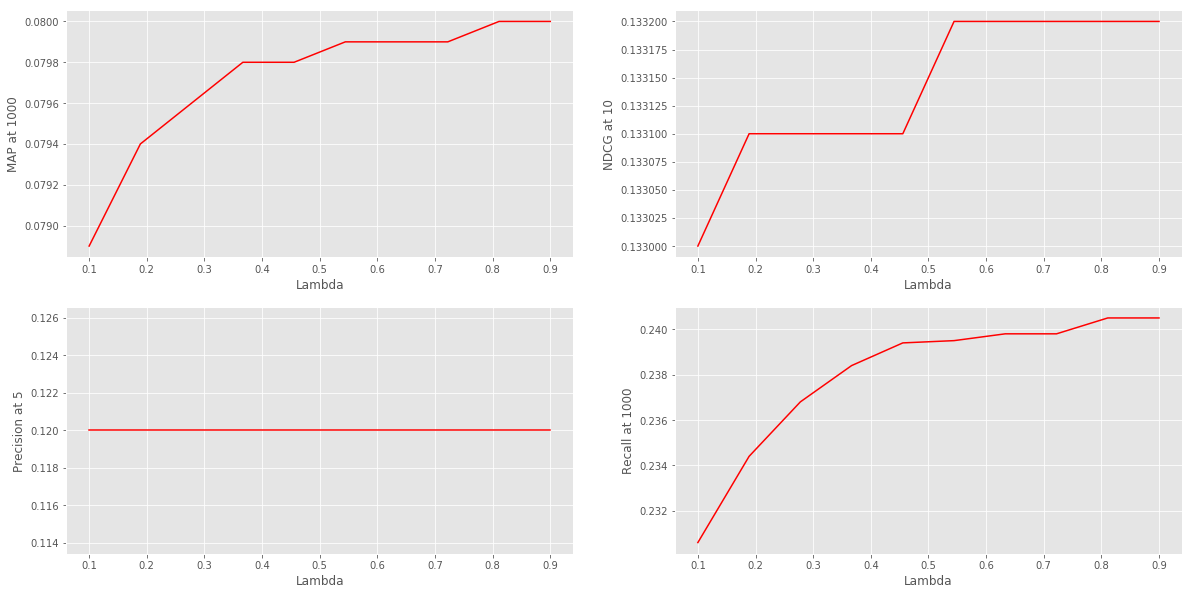

Mu for Dirichlet


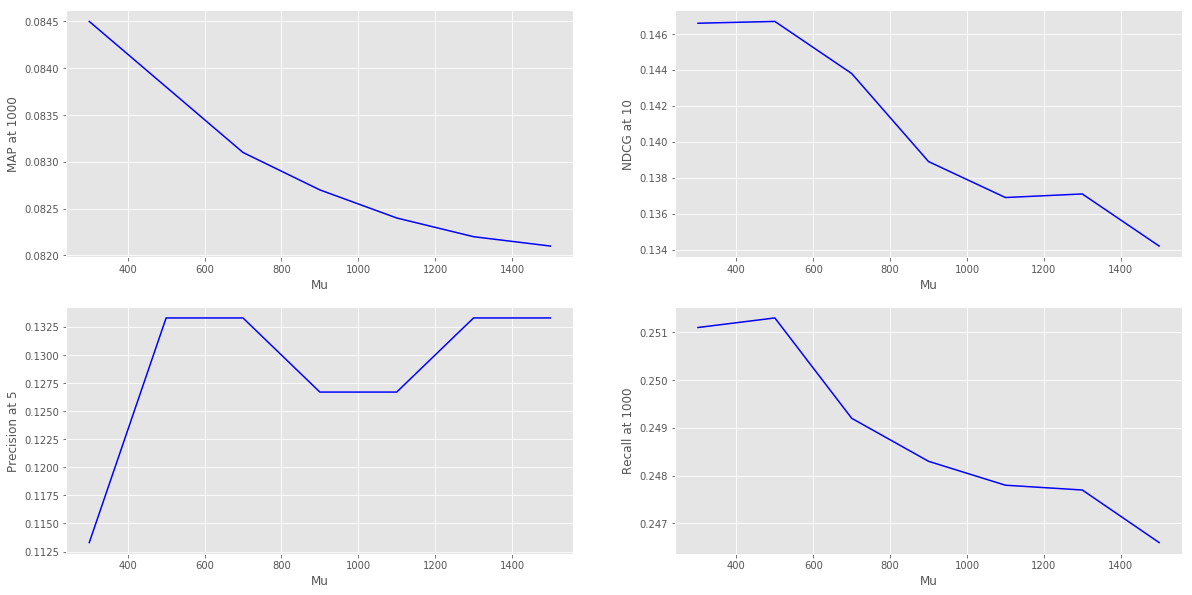

Delta for Absolute Discounting


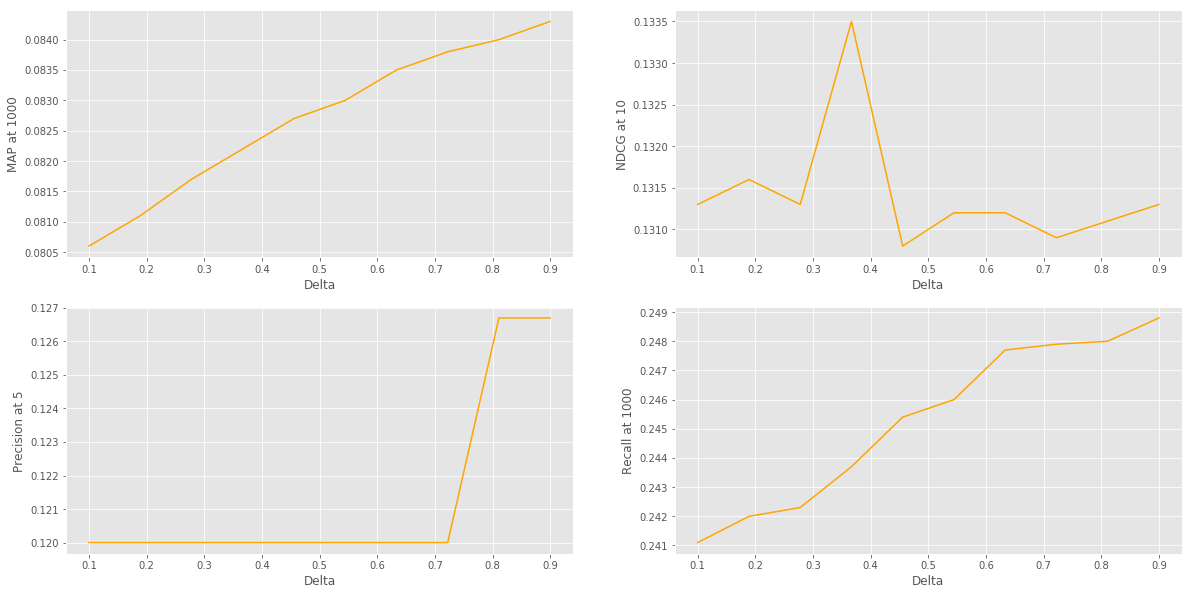

In [143]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)
plt.style.use('ggplot')

#TODO: UPDATE DIRICHLET_PRIOR PARAM MU
lmbds_x = []
recalls_y = []
maps_y = []
ndcgs_y = []
precs_y = []

for jm in jelinek_mercer_grid_results:
    lmbds_x.append(jm[0]['lmbd'])
    recalls_y.append(jm[1]['recall_1000'])
    maps_y.append(jm[1]['map_cut_1000'])
    ndcgs_y.append(jm[1]['ndcg_cut_10'])
    precs_y.append(jm[1]['P_5'])

print("Lambda for Jelinek-Mercer")

plt.subplot(2,2,1)
plt.plot(lmbds_x, maps_y, c="red")
plt.xlabel("Lambda")
plt.ylabel("MAP at 1000")

plt.subplot(2,2,2)
plt.plot(lmbds_x, ndcgs_y, c="red")
plt.xlabel("Lambda")
plt.ylabel("NDCG at 10")

plt.subplot(2,2,3)
plt.plot(lmbds_x, precs_y, c="red")
plt.xlabel("Lambda")
plt.ylabel("Precision at 5")

plt.subplot(2,2,4)
plt.plot(lmbds_x, recalls_y, c="red")
plt.xlabel("Lambda")
plt.ylabel("Recall at 1000")

plt.savefig('lambda.png', format='png', bbox_inches='tight',dpi=600)

plt.show()


mus_x = []
recalls_y = []
maps_y = []
ndcgs_y = []
precs_y = []

for dg in dirichlet_grid_results:
    mus_x.append(dg[0]['mu'])
    recalls_y.append(dg[1]['recall_1000'])
    maps_y.append(dg[1]['map_cut_1000'])
    ndcgs_y.append(dg[1]['ndcg_cut_10'])
    precs_y.append(dg[1]['P_5'])

print("Mu for Dirichlet")

plt.subplot(2,2,1)
plt.plot(mus_x, maps_y, c="blue")
plt.xlabel("Mu")
plt.ylabel("MAP at 1000")

plt.subplot(2,2,2)
plt.plot(mus_x, ndcgs_y, c="blue")
plt.xlabel("Mu")
plt.ylabel("NDCG at 10")

plt.subplot(2,2,3)
plt.plot(mus_x, precs_y, c="blue")
plt.xlabel("Mu")
plt.ylabel("Precision at 5")

plt.subplot(2,2,4)
plt.plot(mus_x, recalls_y, c="blue")
plt.xlabel("Mu")
plt.ylabel("Recall at 1000")

plt.savefig('mu.png', format='png', bbox_inches='tight',dpi=600)

plt.show()


deltas_x = []
recalls_y = []
maps_y = []
ndcgs_y = []
precs_y = []

for ad in abs_discounting_grid:
    deltas_x.append(ad[0]['delta'])
    recalls_y.append(ad[1]['recall_1000'])
    maps_y.append(ad[1]['map_cut_1000'])
    ndcgs_y.append(ad[1]['ndcg_cut_10'])
    precs_y.append(ad[1]['P_5'])

print("Delta for Absolute Discounting")

plt.subplot(2,2,1)
plt.plot(deltas_x, maps_y, c="orange")
plt.xlabel("Delta")
plt.ylabel("MAP at 1000")

plt.subplot(2,2,2)
plt.plot(deltas_x, ndcgs_y, c="orange")
plt.xlabel("Delta")
plt.ylabel("NDCG at 10")

plt.subplot(2,2,3)
plt.plot(deltas_x, precs_y, c="orange")
plt.xlabel("Delta")
plt.ylabel("Precision at 5")

plt.subplot(2,2,4)
plt.plot(deltas_x, recalls_y, c="orange")
plt.xlabel("Delta")
plt.ylabel("Recall at 1000")

plt.savefig('delta.png', format='png', bbox_inches='tight',dpi=600)

plt.show()

Kernel Types for PLM


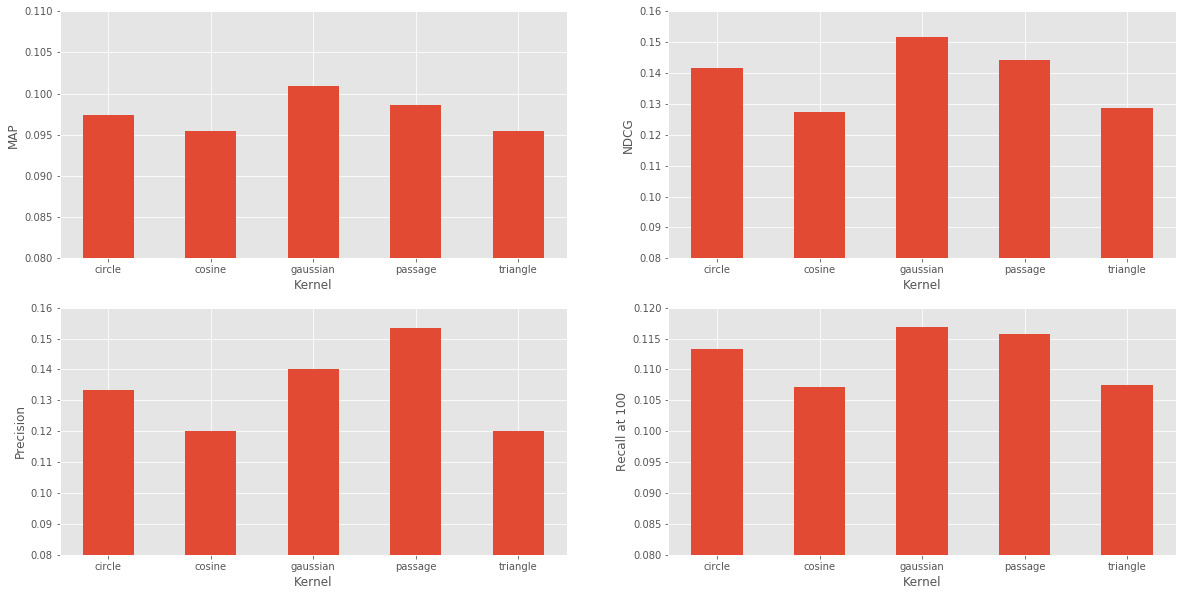

In [141]:
kernels_x = ['gaussian', 'triangle', 'cosine', 'circle', 'passage']
recalls_y = []
maps_y = []
ndcgs_y = []
precs_y = []

for pg in PLM_grid:
    recalls_y.append(pg[1]['recall_100'])
    maps_y.append(pg[1]['map_cut_1000'])
    ndcgs_y.append(pg[1]['ndcg_cut_10'])
    precs_y.append(pg[1]['P_5'])

print("Kernel Types for PLM")

plt.subplot(2,2,1)
plt.bar(kernels_x, maps_y, width=0.5)
plt.ylim(0.08, 0.11)
plt.xlabel("Kernel")
plt.ylabel("MAP")

plt.subplot(2,2,2)
plt.bar(kernels_x, ndcgs_y, width=0.5)
plt.ylim(0.08, 0.16)
plt.xlabel("Kernel")
plt.ylabel("NDCG")

plt.subplot(2,2,3)
plt.bar(kernels_x, precs_y, width=0.5)
plt.ylim(0.08, 0.16)
plt.xlabel("Kernel")
plt.ylabel("Precision")

plt.subplot(2,2,4)
plt.bar(kernels_x, recalls_y, width=0.5)
plt.ylim(0.08, 0.12)
plt.xlabel("Kernel")
plt.ylabel("Recall at 100")

plt.savefig('kernels.png', format='png', bbox_inches='tight',dpi=600)

plt.show()

### Statistical Significance Tests

TODO: Marco, do your magic, broer

In [120]:
results_tfidf = trec.evaluate("./ap_88_89/qrel_test", "./tfidf.run")
results_dirichlet = trec.evaluate("./ap_88_89/qrel_test", "./dirichlet_prior.run")
results_abs_disc = trec.evaluate("./ap_88_89/qrel_test", "./absolute_discounting.run")
results_bm25 = trec.evaluate("./ap_88_89/qrel_test", "./bm25.run")
results_jelinek = trec.evaluate("./ap_88_89/qrel_test", "./jelinek_mercer.run")
results_PLM = trec.evaluate("./ap_88_89/qrel_test", "./PLM_gaussian.run", metrics_to_capture = {"ndcg_cut_10", "map_cut_1000", "P_5", "recall_1000", "recall_100"}) #gaussian is selected in the previous part

# remove results for 'all', since we are performing analysis only on a query level
results_dirichlet.pop('all')
results_tfidf.pop('all')
results_abs_disc.pop('all')
results_bm25.pop('all')
results_jelinek.pop('all')
results_PLM.pop('all')

print("Extracted results!")

Extracted results!


In [160]:
maps_dirichlet = []
maps_tfidf = []
maps_abs_disc = []
maps_bm25 = []
maps_jelinek = []
maps_PLM = []
q_lengths = []

map_key = 'map_cut_1000'
#print(len(results_dirichlet))
for q in results_dirichlet:
    q_lengths.append(len(tokenized_queries[q]))
    maps_dirichlet.append(results_dirichlet[q][map_key])    
    maps_tfidf.append(results_tfidf[q][map_key])
    maps_abs_disc.append(results_abs_disc[q][map_key])
    maps_bm25.append(results_bm25[q][map_key])
    maps_jelinek.append(results_jelinek[q][map_key])    
    maps_PLM.append(results_PLM[q][map_key])

Lengths vs. Performance
m: -0.0210804763361 c: 0.303704159339 for y = m*x + c
Correlation coefficient: -0.197162468837 
p: 0.0308940995982


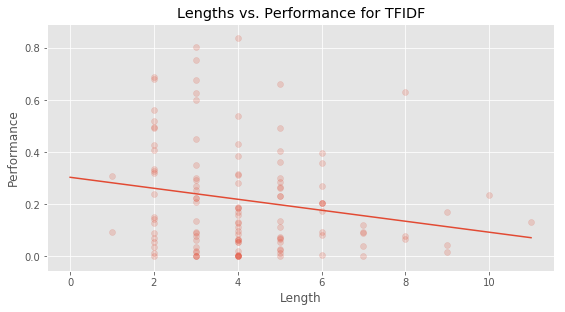

m: -0.00989134490404 c: 0.0606104595153 for y = m*x + c
Correlation coefficient: -0.318229394188 
p: 0.00039697780333


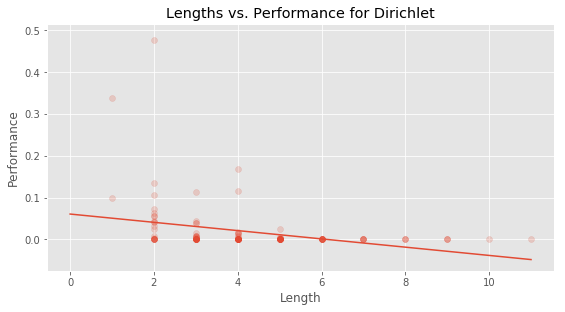

m: -0.00897852282285 c: 0.0544118204756 for y = m*x + c
Correlation coefficient: -0.299357880381 
p: 0.000895385173135


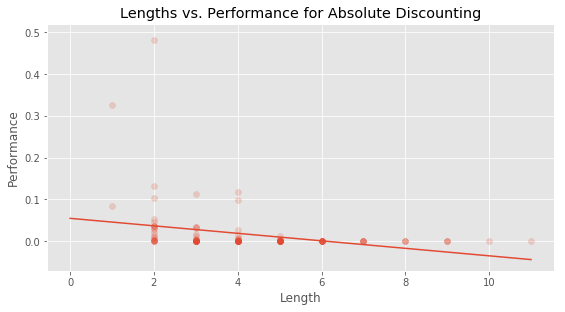

m: -0.00810932793027 c: 0.0489056885083 for y = m*x + c
Correlation coefficient: -0.301194488428 
p: 0.000829183513109


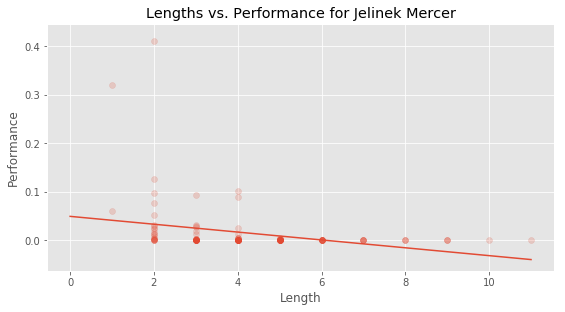

m: -0.00965571526875 c: 0.0842780755409 for y = m*x + c
Correlation coefficient: -0.284978890352 
p: 0.00160609530634


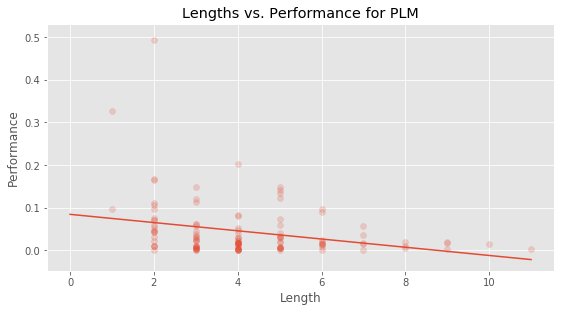

In [236]:
print("Lengths vs. Performance")

def plot_length_performance(q_performances, model_name):
    
    plt.subplot(2,2,1)
    plt.scatter(q_lengths, q_performances, alpha = 0.2)

    z,p = stats.pearsonr(q_lengths,q_performances)
    A = np.vstack([q_lengths, np.ones(len(q_lengths))]).T

    m, c = np.linalg.lstsq(A,q_performances)[0]
    print('m:',m,'c:',c,'for y = m*x + c')

    x = np.linspace(0,max(q_lengths))
    y = m*x + c

    plt.plot(x,y)
    title = 'Lengths vs. Performance for ' + model_name
    plt.title(title)

    print('Correlation coefficient:',z,'\np:',p)
    plt.xlabel("Length")
    plt.ylabel("Performance")

    fig_name = 'length_performance_' + model_name + '.png'
    plt.savefig(fig_name, format='png', bbox_inches='tight',dpi=600)

    plt.show()
    
    
plot_length_performance(maps_tfidf, 'TFIDF')
plot_length_performance(maps_dirichlet, 'Dirichlet')
plot_length_performance(maps_abs_disc, 'Absolute Discounting')
plot_length_performance(maps_jelinek, 'Jelinek Mercer')
plot_length_performance(maps_PLM, 'PLM')

In [145]:
def toss_coin(heads = 0.5):
    # head = True, Tails is False
    return True if random.random() < heads else False

def bonferroni(groups, alpha = 0.05):
    comparisons = math.factorial(groups)/(math.factorial(2)*math.factorial(groups - 2))
    return alpha/comparisons

In [146]:
def randomiser(list_a, list_b, N = 10):
    """
    TODO
    """
    assert len(list_a) == len(list_b)
    for i in range(N):
        new_a, new_b = [], []
        
        for index in range(len(list_a)):
            if toss_coin():
                # don't swap, copy from source
                new_a.append(list_a[index])
                new_b.append(list_b[index])
            else:
                new_a.append(list_b[index])
                new_b.append(list_a[index])
        mean_new_a = np.mean(new_a)
        mean_new_b = np.mean(new_b)
        
        yield mean_new_a, mean_new_b
        
a = np.transpose(list(randomiser([1,2,3],[4,5,6])))
print(a)
z, p = stats.ttest_rel(a[0],a[1])

print(z,p)

[[ 4.  3.  5.  3.  4.  3.  4.  3.  4.  3.]
 [ 3.  4.  2.  4.  3.  4.  3.  4.  3.  4.]]
0.452267016867 0.661780330519


In [147]:
import itertools
maps = ['maps_dirichlet', 'maps_tfidf', 'maps_abs_disc', 'maps_bm25', 'maps_jelinek', 'maps_PLM']
values_map = {'maps_dirichlet':maps_dirichlet, 'maps_tfidf':maps_tfidf, 'maps_abs_disc':maps_abs_disc, 'maps_bm25':maps_bm25, 'maps_jelinek':maps_jelinek, 'maps_PLM':maps_PLM}
comparison_pairs = itertools.combinations(maps,2)

print(bonferroni(10)) 

for x,y in comparison_pairs:
    if x != y:
        #a = np.transpose(list(randomiser(values_map[x],values_map[y])))
        #print(x, y, stats.ttest_rel(a[0],a[1]))
        
        #without randomisation
        print(x, y, stats.ttest_rel(values_map[x],values_map[y]))
        

0.0011111111111111111
maps_dirichlet maps_tfidf Ttest_relResult(statistic=-10.592451683957091, pvalue=7.149705824559884e-19)
maps_dirichlet maps_abs_disc Ttest_relResult(statistic=3.4789468361787539, pvalue=0.00070408155353445868)
maps_dirichlet maps_bm25 Ttest_relResult(statistic=-10.295483877048476, pvalue=3.6583426970362251e-18)
maps_dirichlet maps_jelinek Ttest_relResult(statistic=3.4411986170374531, pvalue=0.00079963657734548799)
maps_dirichlet maps_PLM Ttest_relResult(statistic=-6.8958847693941001, pvalue=2.7511383995675943e-10)
maps_tfidf maps_abs_disc Ttest_relResult(statistic=10.713973693723805, pvalue=3.6648508501590538e-19)
maps_tfidf maps_bm25 Ttest_relResult(statistic=-0.33359901878771864, pvalue=0.73926926415945182)
maps_tfidf maps_jelinek Ttest_relResult(statistic=10.828665062453693, pvalue=1.9504404793278223e-19)
maps_tfidf maps_PLM Ttest_relResult(statistic=9.8235320383706615, pvalue=4.8765115265890585e-17)
maps_abs_disc maps_bm25 Ttest_relResult(statistic=-10.44167701

In [190]:
tfidf_score_distribution = []

for tr in tfidf_run:
    for pair in tfidf_run[tr]:
        tfidf_score_distribution.append(pair[0])

Min TFIDF: 0.5283197478597805 
Max TFIDF: 48.97780043839443
Number of scores: 3568531
normality p: 0.0


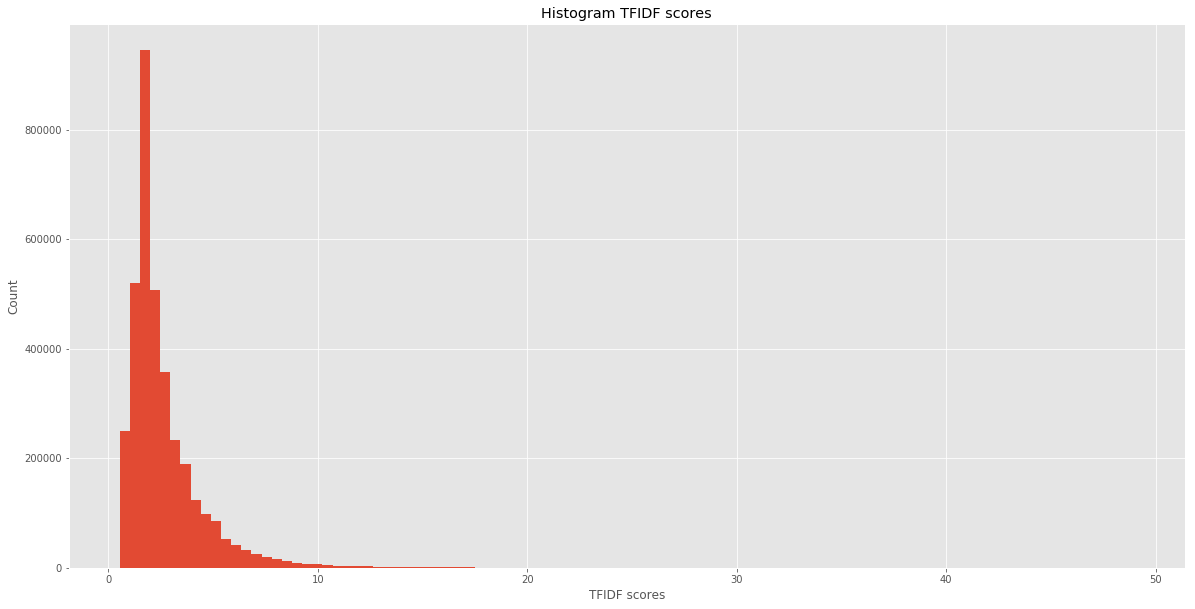

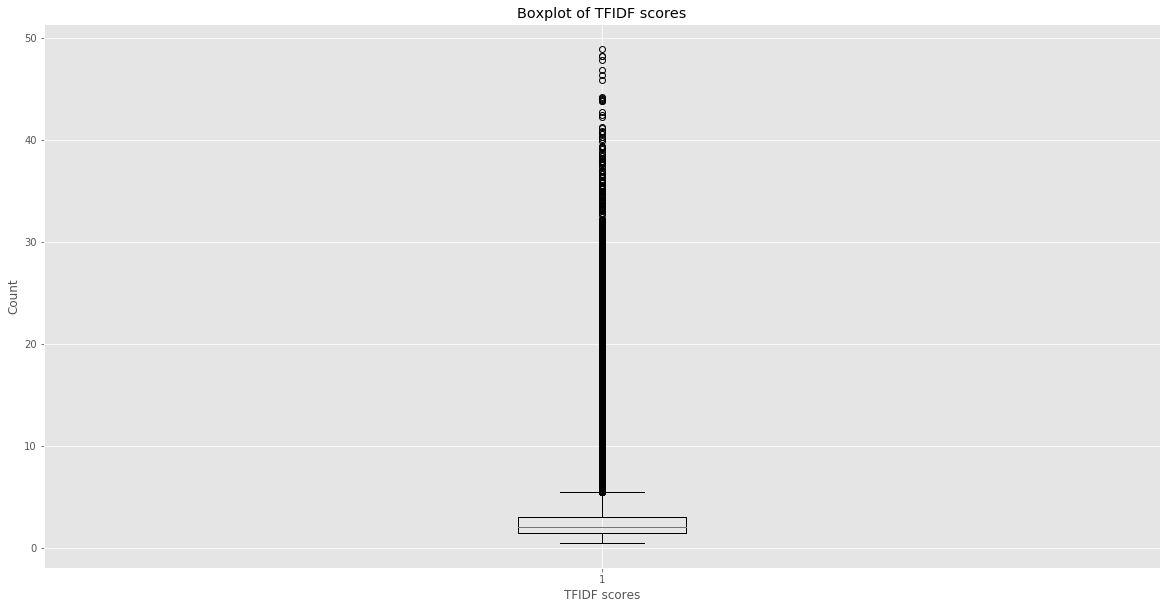

In [234]:
min_score = min(tfidf_score_distribution)
max_score = max(tfidf_score_distribution)
print('Min TFIDF:', min_score,'\nMax TFIDF:', max_score)
print('Number of scores:',len(tfidf_score_distribution))
s,p = stats.normaltest(tfidf_score_distribution)
print('normality p:',p)
plt.title('Histogram TFIDF scores')
plt.xlabel("TFIDF scores")
plt.ylabel("Count")
plt.hist(tfidf_score_distribution, bins=100)
plt.show()

plt.title('Boxplot of TFIDF scores')
plt.xlabel("TFIDF scores")
plt.ylabel("Count")
plt.boxplot(tfidf_score_distribution)
plt.show()



In [208]:
tfidf_queries = collections.defaultdict(lambda: collections.defaultdict(float))

for tr in tfidf_run:
    for pair in tfidf_run[tr]:
        tfidf_queries[tr][pair[1]] = pair[0]
        if(pair[0]>40):
            tq = tokenized_queries[tr]
            q_words = []
            for t in tq:
                q_words.append(id2token[t])
            print(pair[1], tr, q_words)
            #print(doc_tokens_with_stop[ext_id_to_doc_id[pair[1]]])

AP881110-0035 170 ['consequences', 'implantation', 'silicone', 'gel', 'breast', 'devices']
AP881111-0092 170 ['consequences', 'implantation', 'silicone', 'gel', 'breast', 'devices']
AP881122-0171 170 ['consequences', 'implantation', 'silicone', 'gel', 'breast', 'devices']
AP890801-0251 127 ['u', 's', 'u', 's', 's', 'r', 'arms', 'control', 'agreements']
AP890301-0239 127 ['u', 's', 'u', 's', 's', 'r', 'arms', 'control', 'agreements']
AP890713-0230 90 ['data', 'proven', 'reserves', 'oil', 'natural', 'gas', 'producers']
AP890626-0006 163 ['vietnam', 'veterans', 'agent', 'orange']
AP890622-0264 163 ['vietnam', 'veterans', 'agent', 'orange']
AP890716-0034 163 ['vietnam', 'veterans', 'agent', 'orange']
AP890512-0009 163 ['vietnam', 'veterans', 'agent', 'orange']
AP890803-0120 163 ['vietnam', 'veterans', 'agent', 'orange']
AP891030-0013 163 ['vietnam', 'veterans', 'agent', 'orange']
AP890509-0015 163 ['vietnam', 'veterans', 'agent', 'orange']
AP881030-0049 101 ['design', 'star', 'wars', 'anti

In [227]:
bm25_queries = collections.defaultdict(lambda: collections.defaultdict(float))
jm_queries = collections.defaultdict(lambda: collections.defaultdict(float))
dprior_queries = collections.defaultdict(lambda: collections.defaultdict(float))
ab_queries = collections.defaultdict(lambda: collections.defaultdict(float))
tfidf_queries = collections.defaultdict(lambda: collections.defaultdict(float))

print('tfidf')
for q in tfidf_run:
    for pair in tfidf_run[q]:
        tfidf_queries[q][pair[1]] = pair[0]
            
print('bm25')     
for q in bm25_run:
    for pair in bm25_run[q]:
        bm25_queries[q][pair[1]] = pair[0]

print('jm')     
for q in jm_run:
    for pair in jm_run[q]:
        jm_queries[q][pair[1]] = pair[0]

print('ab')     
for q in ab_run:
    for pair in ab_run[q]:
        ab_queries[q][pair[1]] = pair[0]

print('dp')     
for q in dprior_run:
    for pair in dprior_run[q]:
        dprior_queries[q][pair[1]] = pair[0]


tfidf
bm25
jm
ab
dp


In [229]:
for q in tfidf_run:
    for pair in tfidf_run[q]:
        tfidf_queries[q][pair[1]] = pair[0]
        if(pair[0]>40):
            tq = tokenized_queries[q]
            q_words = []
            for t in tq:
                q_words.append(id2token[t])
            print(pair[1], q, q_words)
            print(tfidf_queries[q][pair[1]])
            print(ab_queries[q][pair[1]])
            print(jm_queries[q][pair[1]])
            print(dprior_queries[q][pair[1]])
            print(bm25_queries[q][pair[1]])

AP881110-0035 170 ['consequences', 'implantation', 'silicone', 'gel', 'breast', 'devices']
48.97780043839443
-18.1681394753
-17.8566435152
-20.8725839815
47.1389355384037
AP881111-0092 170 ['consequences', 'implantation', 'silicone', 'gel', 'breast', 'devices']
47.89760285494973
-18.5712809139
-18.2145101625
-21.0835492802
45.952846621445865
AP881122-0171 170 ['consequences', 'implantation', 'silicone', 'gel', 'breast', 'devices']
44.09345991751773
-18.3640091709
-17.8610357353
-21.362525534
46.53903683798915
AP890801-0251 127 ['u', 's', 'u', 's', 's', 'r', 'arms', 'control', 'agreements']
46.91756154980078
-15.601240119
-16.2981802656
-20.379568495
35.64318096635692
AP890301-0239 127 ['u', 's', 'u', 's', 's', 'r', 'arms', 'control', 'agreements']
46.46389266094762
-8.36843349023
-8.91244963002
-10.2929568015
27.548078244851233
AP890713-0230 90 ['data', 'proven', 'reserves', 'oil', 'natural', 'gas', 'producers']
45.914627380475736
-31.3742008641
-29.5972087356
-31.4679421328
31.0795566

### Task 2: Latent Semantic Models (LSMs) [15 points] ###

In this task you will experiment with applying distributional semantics methods ([LSI](http://lsa3.colorado.edu/papers/JASIS.lsi.90.pdf) **[5 points]** and [LDA](https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf) **[5 points]**) for retrieval.

You do not need to implement LSI or LDA on your own. Instead, you can use [gensim](http://radimrehurek.com/gensim/index.html). An example on how to integrate Pyndri with Gensim for word2vec can be found [here](https://github.com/cvangysel/pyndri/blob/master/examples/word2vec.py). For the remaining latent vector space models, you will need to implement connector classes (such as `IndriSentences`) by yourself.

In order to use a latent semantic model for retrieval, you need to:
   * build a representation of the query **q**,
   * build a representation of the document **d**,
   * calculate the similarity between **q** and **d** (e.g., cosine similarity, KL-divergence).
     
The exact implementation here depends on the latent semantic model you are using. 
   
Each of these LSMs come with various hyperparameters to tune. Make a choice on the parameters, and explicitly mention the reasons that led you to these decisions. You can use the validation set to optimize hyper parameters you see fit; motivate your decisions. In addition, mention clearly how the query/document representations were constructed for each LSM and explain your choices.

In this experiment, you will first obtain an initial top-1000 ranking for each query using TF-IDF in **Task 1**, and then re-rank the documents using the LSMs. Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

Perform significance testing **[5 points]** (similar as in Task 1) in the class of semantic matching methods.

In [20]:
def document_token_iterator():
    """
    A generator to iterate over all the indexed documents and return the tokens.
    """
    
    for int_doc_id in range(index.document_base(), index.maximum_document()):
        ext_doc_id, doc_token_ids = index.document(int_doc_id)
        # exclude stopwords and return the word itself 
        # so that we can interpret some of the model's output later on
        ll = [id2token[token_id].lower() for token_id in doc_token_ids if token_id > 0]
        yield ll

In [21]:
def get_dictionary(dict_file_name = "./index.dict"):
    """
    Construct a gensim dictionary from the data, and save it. If this is already done, 
    it loads the existing file and returns it
    
    :param dict_file_name: The path to persist the dictionary to
    """
    
    if os.path.exists(dict_file_name):
        print("Loading existing dictionary")
        return gensim.corpora.Dictionary.load(dict_file_name)
    
    print("Creating dictionary, and saving...")
    gensim_dict = gensim.corpora.Dictionary(document_token_iterator())
    gensim_dict.save(dict_file_name)
    return gensim_dict

gensim_dict = get_dictionary()

Loading existing dictionary


In [22]:
def get_corpus(gensim_dict, corpus_file="ir1.mm"):
    """
    Construct a gensim MmCorpus from the data, and save it. If this is already done, 
    it loads the existing file and returns it
    
    :param dict_file_name: The path to persist the MmCorpus to
    """
    
    if os.path.exists(corpus_file):
        print("Loading existing corpus")
        return gensim.corpora.MmCorpus(corpus_file)
    
    print("Creating corpus, and saving....")
    gensim.corpora.MmCorpus.serialize(corpus_file, (gensim_dict.doc2bow(doc) for doc in document_token_iterator()))
    return gensim.corpora.MmCorpus(corpus_file)

gensim_corpus = get_corpus(gensim_dict)

Loading existing corpus


In [23]:
def get_LSI_model(num_topics=256, directory="./models/"):
    """
    Construct a LSI model and save it. If it already exists, load it.
    :param num_topics: The number of topics to train the model on
    :param directory: The directory to save the model to / load the model from
    
    """
    model_path = os.path.join(directory, "lsi_model_{}".format(num_topics))
    
    if os.path.exists(model_path):
        print("Loading existing model from ", model_path)
        return gensim.models.lsimodel.LsiModel.load(model_path)
    
    print("Creating LSI model, and saving to ", model_path)
    lsi_model = gensim.models.lsimodel.LsiModel(corpus=gensim_corpus, id2word=gensim_dict, num_topics=num_topics)
    lsi_model.save(model_path)
    return lsi_model

In [24]:
def get_LDA_model(num_topics=256, directory="./models/"):
    """
    Construct a LDA model and save it. If it already exists, load it.
    :param num_topics: The number of topics to train the model on
    :param directory: The directory to save the model to / load the model from
    
    """
    model_path = os.path.join(directory, "lda_model_{}".format(num_topics))
    
    if os.path.exists(model_path):
        print("Loading existing model from ", model_path)
        return gensim.models.LdaModel.load(model_path)
    
    print("Creating LDA model, and saving to ", model_path)
    lda_model = gensim.models.LdaModel(corpus=gensim_corpus, id2word=gensim_dict, num_topics=num_topics)
    lda_model.save(model_path)
    return lda_model

In [30]:
class LSMScorer:
    """
    A scorer for a LSM 
    """
    
    def __init__(self, corpus, dictionary, model):
        """
        Initialize a LSM scorer
        
        :param corpus: The gensim corpus instance
        :param dictionary: The gensim dictionary instance
        :param model: The LSM 
        """
        
        self.model = model
        self.corpus = corpus
        self.dict = dictionary
        
        # a matrix holding all the document vectors
        self.document_vectors = np.zeros((num_documents, self.model.num_topics))
        # index (of the matrix above) -> external doc id
        self.document_index = []
        start_time = time.time()
        print("Starting pre-indexing")
        # pre-index the document vectors for faster computation
        for idx, int_doc_id in enumerate(range(index.document_base(), index.maximum_document())):
            if (idx + 1) % 10000 == 0:
                print(idx, " documents indexed. Time elapsed:", time.time() - start_time)
            ext_doc_id, doc_token_ids = index.document(int_doc_id)
            document_tokens = [id2token[token_id].lower() for token_id in doc_token_ids if token_id > 0]
            self.document_index.append(ext_doc_id)
            self.document_vectors[idx] = self._get_vector(document_tokens)    
    
    def _get_vector(self, tokens):
        """
        Construct a vector representing the topics from the LSM 
        
        :param tokens: The list of tokens (from the corpus)
        """
        
        vector = np.zeros(self.model.num_topics)
        # TODO why isn't the size always = num_topics? It's super strange! 
        # TODO check back why this is happening. it's a serious problem
        for topic, value in self.model[self.dict.doc2bow(tokens)]:
            vector[topic] = value
        
        return vector
    
    def score(self, query_tokens):
        """
        Score a particular query against all documents
        
        :param query_tokens: A list of tokens (strings)
        """
        
        # TODO order = 1 same, -1 not same
        # TODO cehck others as well
        # TODO some values are 
        # TODO have to use JS divergence
        # convert to a vector
        query_vector = self._get_vector(query_tokens)
        # compute distances - using the vectorized form of the cosine distance
        distances = np.apply_along_axis(lambda _: -(cosine_distance(query_vector, _) - 1), 1, self.document_vectors)
        results = list(zip(distances, self.document_index))
        results.sort(key=lambda _: -_[0])
        return results

def get_LSI_scorer(model, directory="./models"):
    """
    Construct a LSI scorer and save it. If it already exists, load it.
    :param model: The LSI model
    :param directory: The directory to save the model to / load the model from
    
    """
    model_path = os.path.join(directory, "lsi_scorer_{}.pkl".format(model.num_topics))
    
    if os.path.exists(model_path):
        print("Loading existing scorer from ", model_path)
        return pickle.load(open(model_path, "rb"))
    
    print("Creating LSI scorer, and saving to ", model_path)
    lsi_scorer = LSMScorer(gensim_corpus, gensim_dict, model)
    pickle.dump(lsi_scorer, open(model_path, "wb"))
    return lsi_scorer

def get_LDA_scorer(model, directory="./models"):
    """
    Construct a LDA scorer and save it. If it already exists, load it.
    :param model: The LDA model
    :param directory: The directory to save the model to / load the model from
    
    """
    model_path = os.path.join(directory, "lda_scorer_{}.pkl".format(model.num_topics))
    
    if os.path.exists(model_path):
        print("Loading existing scorer from ", model_path)
        return pickle.load(open(model_path, "rb"))
    
    print("Creating LDA scorer, and saving to ", model_path)
    lda_scorer = LSMScorer(gensim_corpus, gensim_dict, model)
    pickle.dump(lda_scorer, open(model_path, "wb"))
    return lda_scorer


In [31]:
def run_retrieval_lsm(model_name, scorer):
    """
    Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: the name of the model (a string)
    :param scorer: the LSMScorer 
    """
    
    run_out_path = '{}.run'.format(model_name)

    #if os.path.exists(run_out_path):
    #    return

    retrieval_start_time = time.time()

    print('Retrieving using', model_name)
    
    data = {}
    start_time = time.time()
    for index, (query_id, query_tokens) in enumerate(tokenized_queries.items()):
        query_tokens = [id2token[token_id].lower() for token_id in query_tokens if token_id > 0]
        data[query_id] = scorer.score(query_tokens)
        if (index + 1) % 10 == 0:
            print("\t", index + 1 , "done.", time.time() - start_time, "elapsed" )

    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)

#### Parameter tuning for LSI & LDA


In [32]:
lsi_grid = []
for num_topics in [32, 64, 128, 256, 512]:
    run_name = "lsi_{}".format(num_topics)
    run_file_name = run_name + ".run"
    if not os.path.exists(run_file_name):
        lsi_model = get_LSI_model(num_topics=num_topics)
        lsi_scorer = get_LSI_scorer(lsi_model)
        run_retrieval_lsm(run_name, lsi_scorer)
        
        del lsi_model
        del lsi_scorer
    lsi_grid.append((num_topics, trec.evaluate("./ap_88_89/qrel_validation", run_file_name, granular=False)))

print_grid(lsi_grid)    

Params:  32
	Results:  {'P_5': 0.0533, 'map_cut_1000': 0.0077, 'recall_1000': 0.0928, 'ndcg_cut_10': 0.0378}
Params:  64
	Results:  {'P_5': 0.0533, 'map_cut_1000': 0.0108, 'recall_1000': 0.1328, 'ndcg_cut_10': 0.0551}
Params:  128
	Results:  {'P_5': 0.14, 'map_cut_1000': 0.0251, 'recall_1000': 0.1621, 'ndcg_cut_10': 0.1187}
Params:  256
	Results:  {'P_5': 0.14, 'map_cut_1000': 0.0317, 'recall_1000': 0.1647, 'ndcg_cut_10': 0.1483}
Params:  512
	Results:  {'P_5': 0.18, 'map_cut_1000': 0.0438, 'recall_1000': 0.1702, 'ndcg_cut_10': 0.1677}


In [ ]:
lda_grid = []
for num_topics in [32, 64, 128, 256, 512]:
    run_name = "lda_{}".format(num_topics)
    run_file_name = run_name + ".run"
    if not os.path.exists(run_file_name):
        lda_model = get_LDA_model(num_topics=num_topics)
        lda_scorer = get_LDA_scorer(lda_model)
        run_retrieval_lsm(run_name, lda_scorer)
        
        del lda_model
        del lda_scorer
        
    lda_grid.append((trec.evaluate("./ap_88_89/qrel_validation", run_file_name, granular=False)))

print_grid(lda_grid)    

Loading existing model from  ./models/lda_model_32
Loading existing scorer from  ./models/lda_scorer_32.pkl
Retrieving using lda_32
	 10 done. 48.13765478134155 elapsed
	 20 done. 95.5994873046875 elapsed
	 30 done. 143.0424289703369 elapsed
	 40 done. 190.88942623138428 elapsed
	 50 done. 238.62958931922913 elapsed
	 60 done. 286.16275000572205 elapsed
	 70 done. 333.5838267803192 elapsed
	 80 done. 381.1213300228119 elapsed
	 90 done. 428.54447317123413 elapsed
	 100 done. 476.1043474674225 elapsed
	 110 done. 523.5313837528229 elapsed
	 120 done. 571.1587057113647 elapsed
	 130 done. 618.6215851306915 elapsed
	 140 done. 666.041335105896 elapsed
	 150 done. 713.4328029155731 elapsed
Creating LDA model, and saving to  ./models/lda_model_64
Creating LDA scorer, and saving to  ./models/lda_scorer_64.pkl
Starting pre-indexing
9999  documents indexed. Time elapsed: 81.91984272003174
19999  documents indexed. Time elapsed: 161.24905681610107
29999  documents indexed. Time elapsed: 239.860

/media/samarth/Data/workspaces/uva/ir1/lib/python3.5/site-packages/gensim/models/ldamodel.py:802: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [ ]:
trec.evaluate("./ap_88_89/qrel_validation", "lsi.run", granular=False)

In [ ]:
trec.evaluate("./ap_88_89/qrel_validation", "lda.run", granular=False)

### Task 3:  Word embeddings for ranking [20 points] (open-ended) ###

First create word embeddings on the corpus we provided using [word2vec](http://arxiv.org/abs/1411.2738) -- [gensim implementation](https://radimrehurek.com/gensim/models/word2vec.html). You should extract the indexed documents using pyndri and provide them to gensim for training a model (see example [here](https://github.com/nickvosk/pyndri/blob/master/examples/word2vec.py)).
   
This is an open-ended task. It is left up you to decide how you will combine word embeddings to derive query and document representations. Note that since we provide the implementation for training word2vec, you will be graded based on your creativity on combining word embeddings for building query and document representations.

Note: If you want to experiment with pre-trained word embeddings on a different corpus, you can use the word embeddings we provide alongside the assignment (./data/reduced_vectors_google.txt.tar.gz). These are the [google word2vec word embeddings](https://code.google.com/archive/p/word2vec/), reduced to only the words that appear in the document collection we use in this assignment.

In [35]:
class SentenceIterator:
    def __init__(self, min_count = 5):
        self.min_count = 5
        
    def __iter__(self):
        for sentence in document_token_iterator():
            words = []
            for word in sentence:
                if collection_frequencies[token2id[word]] < self.min_count:
                    word = "UNK"
                words.append(word)
            yield words

In [37]:
def get_word2vec_model(embedding_size=300, iterations=5, directory="./models/"):
    """
    Construct a word2vec model and save it. If it already exists, load it.
    :param embedding_size: The embedding size
    :param directory: The directory to save the model to / load the model from
    
    """
    model_path = os.path.join(directory, "word2vec_model_{}".format(embedding_size))
    
    if os.path.exists(model_path):
        print("Loading existing model from ", model_path)
        return gensim.models.Word2Vec.load(model_path)
    
    print("Creating Word2Vec model, and saving to ", model_path)
    word2vec = word2vec = gensim.models.Word2Vec(
        SentenceIterator(),
        size=embedding_size,  # Embedding size
        window=5,  # One-sided window size
        sg=True,  # Skip-gram.
        min_count=5, # Minimum word frequency.
        sample=1e-3,  # Sub-sample threshold.
        hs=False,  # Hierarchical softmax.
        negative=10,  # Number of negative examples.
        iter=iterations,  # Number of iterations.
        workers=8,  # Number of workers.
    )
    word2vec.save(model_path)
    return word2vec

Loading existing model from  ./models/word2vec_model_300


In [38]:
class Word2VecScorer(LSMScorer):
    def __init__(self, corpus, dictionary, model, scheme):
        self.scheme = scheme
        super().__init__(corpus, dictionary, model)
        
    def _get_vector(self, tokens):
        # remove tokens not in vocab
        all_vectors = np.zeros((len(tokens), self.model.vector_size))
        
        for index, token in enumerate(tokens):
            if token not in self.model:
                token = "UNK"
            all_vectors[index] = self.model[token]
        
        if self.scheme == "avg":
            return all_vectors.mean(axis=0)
        
        if self.scheme == "min":
            return all_vectors.min(axis=0)
        
        if self.scheme == "max":
            return all_vectors.max(axis=0)
        
def get_W2V_scorer(model, scheme, directory="./models"):
    """
    Construct a W2V scorer and save it. If it already exists, load it.
    :param model: The W2V model
    :param directory: The directory to save the model to / load the model from
    
    """
    model_path = os.path.join(directory, "w2v_scorer_{}_{}.pkl".format(model.num_topics, scheme))
    
    if os.path.exists(model_path):
        print("Loading existing scorer from ", model_path)
        return pickle.load(open(model_path, "rb"))
    
    print("Creating W2V scorer, and saving to ", model_path)
    w2v_scorer = Word2VecScorer(gensim_corpus, gensim_dict, model, scheme)
    pickle.dump(w2v_scorer, open(model_path, "wb"))
    return w2v_scorer

Loading existing scorer from  ./models/w2v_scorer_300_avg.pkl


#### Parameter tuning for W2V


In [ ]:
iterations = 5
grid_results = []
for embedding_size in [100, 200, 300]:
    for scheme in ["avg", "min", "max"]:
        run_name = "word2vec_{}_{}".format(embedding_size, scheme)
        run_file_name = run_name + ".run"
        if not os.path.exists(run_file_name):
            word2vec = get_word2vec_model(embedding_size, iterations=iterations)
            word2vec.num_topics = word2vec.vector_size
            w2v_scorer = get_W2V_scorer(word2vec, scheme)
            run_retrieval_lsm(run_name, w2v_scorer)
            
            del word2vec
            del w2v_scorer
            
        res = trec.evaluate("./ap_88_89/qrel_validation", run_file_name, granular=False)
        grid_results.append({"embedding_size": embedding_size, "scheme": scheme}, res)
        
print_grid(grid_results)

### Task 4: Learning to rank (LTR) [15 points] (open-ended) ###

In this task you will get an introduction into learning to rank for information retrieval.

You can explore different ways for devising features for the model. Obviously, you can use the retrieval methods you implemented in Task 1, Task 2 and Task 3 as features. Think about other features you can use (e.g. query/document length). Creativity on devising new features and providing motivation for them will be taken into account when grading.

For every query, first create a document candidate set using the top-1000 documents using TF-IDF, and subsequently compute features given a query and a document. Note that the feature values of different retrieval methods are likely to be distributed differently.

You are adviced to start some pointwise learning to rank algorithm e.g. logistic regression, implemented in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
Train your LTR model using 10-fold cross validation on the test set. More advanced learning to rank algorithms will be appreciated when grading.

In [19]:
from scipy import stats

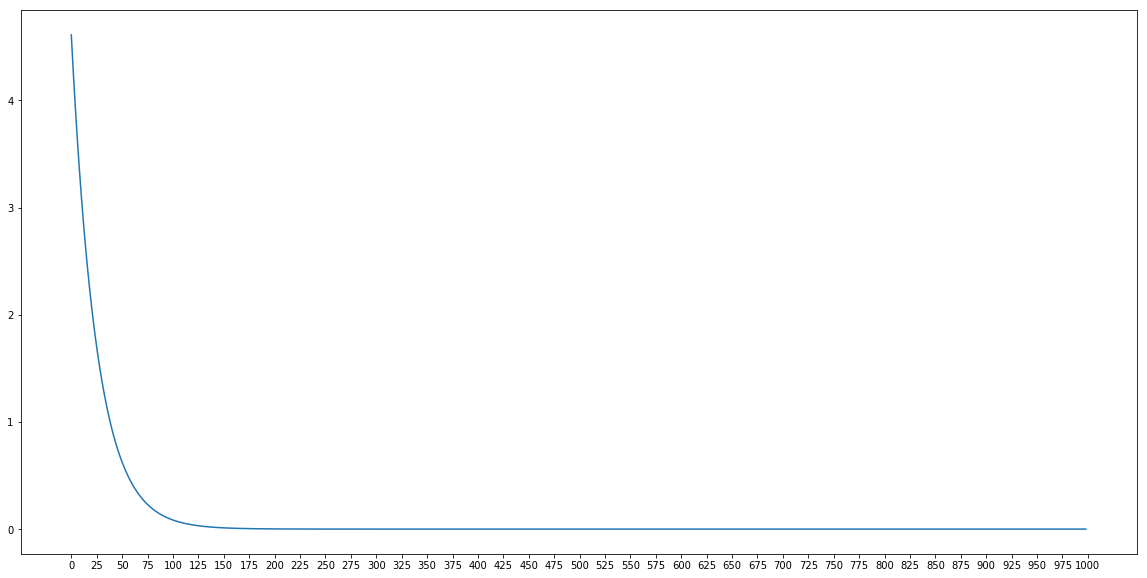

In [20]:
plt.figure(figsize=(20, 10))
plt.xticks(np.arange(0, 1001, 25))
plt.plot(stats.expon.pdf(np.arange(1, 1000), scale=25) * 120) 

In [21]:
np.hstack(([1,2,3], [1,32]))

array([ 1,  2,  3,  1, 32])

TODO Feature norm

In [39]:
doc_tokens = {}
for int_doc_id in range(index.document_base(), index.maximum_document()):
    doc_tokens[int_doc_id] = [ind for ind in index.document(int_doc_id)[1] if ind > 0]

In [53]:
# compute lowest values 
def lowest_value(run):
    min_val = None
    for doc_val in run.values():
        for doc, val in doc_val:
            if min_val is None:
                min_val = val
            min_val = min(min_val, val)
    return min_val

tfidf_min_val = lowest_value(tfidf_run)
bm25_min_val = lowest_value(bm25_run)
dprior_min_val = lowest_value(dprior_run)
ab_min_val = lowest_value(ab_run)
jm_min_val = lowest_value(jm_run)

In [ ]:
def create_score_dict(scores):
    new_scores = {}
    for qid, values in scores.items():
        new_scores[qid] = dict([(ext_id_to_doc_id[v], k) for k, v in values])
    return new_scores


class FeatureCreator:
    def __init__(self):
        pass
        
    def features(self, query_id, int_document_id):
        tf_score = 0.0
        bm25_score = 0.0
        jm_score = 0.0
        dprior_score = 0.0
        ab_run = 0.0 
        
        for query_term_id in tokenized_queries[query_id]:
            tf = inverted_index[query_term_id].get(int_document_id, 0)
            tf_score += tfidf(int_document_id, query_term_id, tf)
            bm25_score += bm25(int_document_id, query_term_id, tf)
            jm_score += jelinek_mercer(int_document_id, query_term_id, tf)
            dprior_score += dirichlet_prior(int_document_id, query_term_id, tf)
            ab_run += absolute_discounting(int_document_id, query_term_id, tf)
            
        q_vector = w2v_scorer._get_vector([id2token[t] for t in tokenized_queries[query_id]])
        d_vector = w2v_scorer._get_vector([id2token[t] for t in doc_tokens[int_document_id]])
        
        vector = np.array([tf_score, bm25_score, jm_score, dprior_score, ab_run])
        vector = np.hstack((vector, q_vector, d_vector))
        return np.array(vector)
    
features = FeatureCreator()

In [ ]:
# use the tf-idf data to create the training matix
def get_x_y():
    if os.path.exists("l2r_x.pkl"):
        x = pickle.load(open("l2r_x.pkl", "rb"))
        y = pickle.load(open("l2r_y.pkl", "rb"))
        qd_index = pickle.load(open("l2r_qd_index.pkl", "rb"))
        return x, y, qd_index
    
    
    x = []
    y = []
    qd_index = []
    for query_id, documents in tfidf_run.items():
        documents = documents[:1000]
        y_values = stats.expon.pdf(np.arange(1, 1001), scale=25) * 120
        for index, (_, ext_doc_id) in enumerate(documents):
            x.append(features.features(query_id, ext_id_to_doc_id[ext_doc_id]))
            y.append(y_values[index])
            qd_index.append((query_id, ext_id_to_doc_id[ext_doc_id]))
    x = np.array(x)
    y = np.array(y)
    
    pickle.dump(x, open("l2r_x.pkl", "wb"))
    pickle.dump(y, open("l2r_y.pkl", "wb"))
    pickle.dump(qd_index, open("l2r_qd_index.pkl", "wb"))
    
    return x, y, qd_index

x, y, qd_index = get_x_y()

/media/samarth/Data/workspaces/uva/ir1/lib/python3.5/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # This is added back by InteractiveShellApp.init_path()
/media/samarth/Data/workspaces/uva/ir1/lib/python3.5/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


In [136]:
from sklearn.linear_model import LinearRegression

In [137]:
from sklearn.model_selection import train_test_split

In [139]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.4)

In [140]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)

In [141]:
regr = LinearRegression()
regr.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [142]:
regr.score(x_train, y_train)

0.29193914153584555

In [143]:
regr.score(x_val, y_val)

0.30285438839717427

In [ ]:
class RankAlgorithm:
    
    def __init__(self, model, features):
        self.model = model
        self.features = features
    
    def score(self, query_id, int_doc_id):
        x = features.features(query_id, int_doc_id)
        self.model

### Task 4: Write a report [15 points; instant FAIL if not provided] ###

The report should be a PDF file created using the [sigconf ACM template](https://www.acm.org/publications/proceedings-template) and will determine a significant part of your grade.

   * It should explain what you have implemented, motivate your experiments and detail what you expect to learn from them. **[10 points]**
   * Lastly, provide a convincing analysis of your results and conclude the report accordingly. **[10 points]**
      * Do all methods perform similarly on all queries? Why?
      * Is there a single retrieval model that outperforms all other retrieval models (i.e., silver bullet)?
      * ...

**Hand in the report and your self-contained implementation source files.** Only send us the files that matter, organized in a well-documented zip/tgz file with clear instructions on how to reproduce your results. That is, we want to be able to regenerate all your results with minimal effort. You can assume that the index and ground-truth information is present in the same file structure as the one we have provided.
